In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix
import ipywidgets as widgets
import io
from PIL import Image
from IPython.display import display,clear_output
from warnings import filterwarnings
!pip install tensorflow-addons==0.8.3
from google.colab import drive
drive.mount('/content/drive')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.0 MB 5.1 MB/s 
Mounted at /content/drive


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


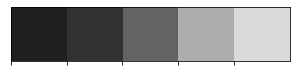

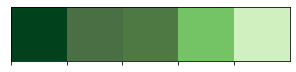

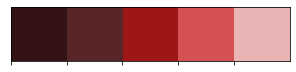

In [3]:
colors_dark = ["#1F1F1F", "#313131", '#636363', '#AEAEAE', '#DADADA']
colors_red = ["#331313", "#582626", '#9E1717', '#D35151', '#E9B4B4']
colors_green = ['#01411C','#4B6F44','#4F7942','#74C365','#D0F0C0']

sns.palplot(colors_dark)
sns.palplot(colors_green)
sns.palplot(colors_red)

In [4]:
labels = ['glioma','notumor','meningioma','pituitary']

In [5]:

X_train = []
y_train = []
image_size = 384
for i in labels:
    folderPath = os.path.join('drive/MyDrive/Brain_tumor_detection/brain_tumor_original_dataset/Training',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_train.append(i)
        
        
X_train = np.array(X_train)
y_train = np.array(y_train)

100%|██████████| 1457/1457 [00:28<00:00, 51.61it/s] 


In [6]:
X_testing = []
y_testing = []
image_size = 384
for i in labels:
    folderPath = os.path.join('drive/MyDrive/Brain_tumor_detection/brain_tumor_original_dataset/Testing',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X_testing.append(img)
        y_testing.append(i)
        
        
X_testing = np.array(X_testing)
y_testing = np.array(y_testing)

100%|██████████| 300/300 [00:03<00:00, 77.05it/s] 


In [7]:
X_test,X_val,y_test,y_val = train_test_split(X_testing,y_testing, test_size=0.3,random_state=101)

In [8]:
X_train, y_train = shuffle(X_train,y_train, random_state=101)

In [9]:
X_train.shape

(5712, 384, 384, 3)

In [10]:
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)


y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

y_val_new = []
for i in y_val:
    y_val_new.append(labels.index(i))
y_val = y_val_new
y_val = tf.keras.utils.to_categorical(y_val)

In [11]:
!pip install --quiet vit-keras
import tensorflow_addons as tfa

from vit_keras import vit

In [12]:
vit_model = vit.vit_l32(
        activation = 'softmax',
        pretrained = True,
        include_top = False,
        pretrained_top = False,
        classes = 4)

1226670080/1226658854 [==============================] - 130s 0us/step


In [13]:
for layer in vit_model.layers:
  layer.trainable = False

In [16]:
model = tf.keras.Sequential([
        vit_model,
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(rate=0.5),
        tf.keras.layers.Dense(4, 'softmax')
    ])


model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vit-l32 (Functional)        (None, 1024)              305607680 
                                                                 
 flatten_1 (Flatten)         (None, 1024)              0         
                                                                 
 dropout_1 (Dropout)         (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 4)                 4100      
                                                                 
Total params: 305,611,780
Trainable params: 4,100
Non-trainable params: 305,607,680
_________________________________________________________________


In [17]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vit-l32 (Functional)        (None, 1024)              305607680 
                                                                 
 flatten_1 (Flatten)         (None, 1024)              0         
                                                                 
 dropout_1 (Dropout)         (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 4)                 4100      
                                                                 
Total params: 305,611,780
Trainable params: 4,100
Non-trainable params: 305,607,680
_________________________________________________________________


In [18]:
sgd = tf.keras.optimizers.SGD(learning_rate=0.005)
model.compile(loss='categorical_crossentropy',optimizer = sgd , metrics= ['accuracy'])

In [19]:
history = model.fit(X_train,y_train,validation_data=(X_val,y_val), epochs =20, verbose=1, batch_size=8)

Epoch 1/20
714/714 [==============================] - 256s 324ms/step - loss: 1.2187 - accuracy: 0.4608 - val_loss: 1.0782 - val_accuracy: 0.6117
Epoch 2/20
714/714 [==============================] - 225s 316ms/step - loss: 0.9833 - accuracy: 0.6124 - val_loss: 0.9964 - val_accuracy: 0.6168
Epoch 3/20
714/714 [==============================] - 225s 315ms/step - loss: 0.9118 - accuracy: 0.6455 - val_loss: 0.9416 - val_accuracy: 0.6396
Epoch 4/20
714/714 [==============================] - 225s 315ms/step - loss: 0.8590 - accuracy: 0.6632 - val_loss: 0.9178 - val_accuracy: 0.6624
Epoch 5/20
714/714 [==============================] - 225s 316ms/step - loss: 0.8262 - accuracy: 0.6831 - val_loss: 0.8866 - val_accuracy: 0.6523
Epoch 6/20
714/714 [==============================] - 225s 315ms/step - loss: 0.8029 - accuracy: 0.6942 - val_loss: 0.8785 - val_accuracy: 0.6701
Epoch 7/20
714/714 [==============================] - 225s 315ms/step - loss: 0.7839 - accuracy: 0.6954 - val_loss: 0.8616 -

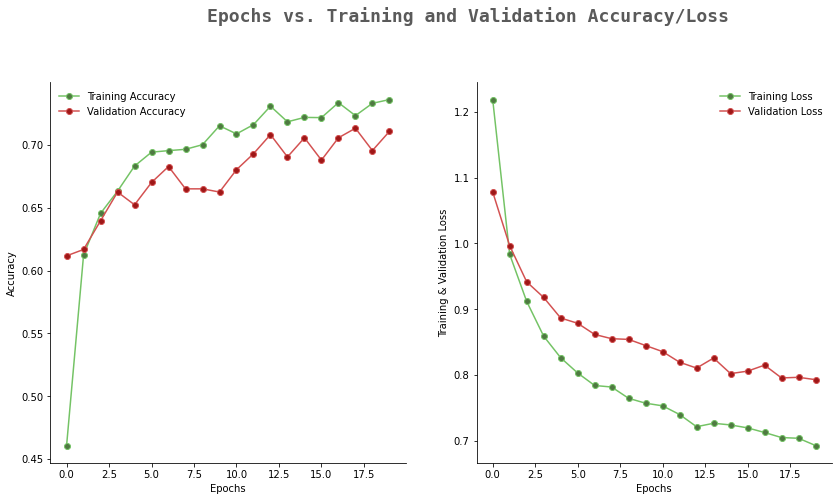

In [20]:
filterwarnings('ignore')

epochs = [i for i in range(20)]
fig, ax = plt.subplots(1,2,figsize=(14,7))
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

fig.text(s='Epochs vs. Training and Validation Accuracy/Loss',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=1,x=0.28,alpha=0.8)

sns.despine()
ax[0].plot(epochs, train_acc, marker='o',markerfacecolor=colors_green[2],color=colors_green[3],
           label = 'Training Accuracy')
ax[0].plot(epochs, val_acc, marker='o',markerfacecolor=colors_red[2],color=colors_red[3],
           label = 'Validation Accuracy')
ax[0].legend(frameon=False)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

sns.despine()
ax[1].plot(epochs, train_loss, marker='o',markerfacecolor=colors_green[2],color=colors_green[3],
           label ='Training Loss')
ax[1].plot(epochs, val_loss, marker='o',markerfacecolor=colors_red[2],color=colors_red[3],
           label = 'Validation Loss')
ax[1].legend(frameon=False)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Training & Validation Loss')

fig.show()

In [21]:
pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)

In [22]:
print(classification_report(y_test_new,pred))

              precision    recall  f1-score   support

           0       0.71      0.57      0.63       197
           1       0.85      0.91      0.88       290
           2       0.52      0.48      0.50       213
           3       0.76      0.86      0.80       217

    accuracy                           0.73       917
   macro avg       0.71      0.71      0.70       917
weighted avg       0.72      0.73      0.72       917



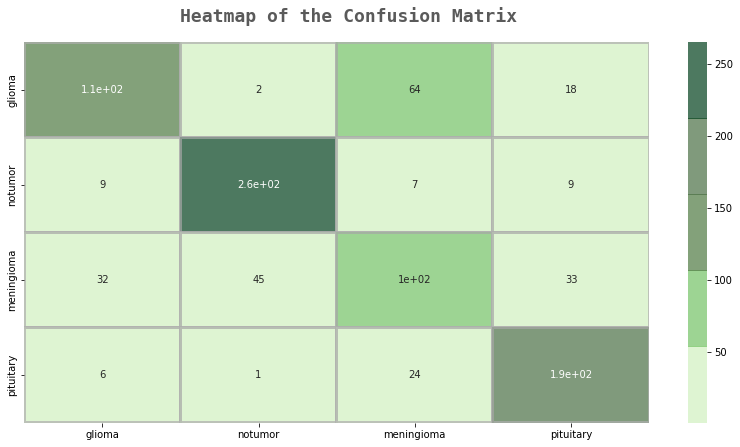

In [23]:
fig,ax=plt.subplots(1,1,figsize=(14,7))
sns.heatmap(confusion_matrix(y_test_new,pred),ax=ax,xticklabels=labels,yticklabels=labels,annot=True,
           cmap=colors_green[::-1],alpha=0.7,linewidths=2,linecolor=colors_dark[3])
fig.text(s='Heatmap of the Confusion Matrix',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=0.92,x=0.28,alpha=0.8)

plt.show()